In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import uproot
import awkward as ak
import concurrent.futures
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, ConcatDataset, random_split
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
from sklearn.metrics import roc_auc_score, roc_curve
from particle_net_model import ParticleNet 

In [2]:
settings = {
    "conv_params": [
        (16, (64, 64, 64)),
        (16, (128, 128, 128)),
        (16, (256, 256, 256)),
    ],
    "fc_params": [
        (0.1, 256)
    ],
    "input_features": 11,
    "output_classes": 1,
    "DEVICE": 'cuda' if torch.cuda.is_available() else 'cpu',
}

print(settings['DEVICE'])

model = ParticleNet(settings)
print(model)

cuda
ParticleNet(
  (input_bn): BatchNorm(11)
  (conv_process): ModuleList(
    (0-2): 3 x ParticleDynamicEdgeConv()
  )
  (fc_process): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Dropout(p=0.1, inplace=False)
      (2): ReLU()
    )
  )
  (output_mlp_linear): Linear(in_features=256, out_features=1, bias=True)
  (output_activation): Softmax(dim=0)
)


In [3]:
fileset = {}

sig_dir = '/mdsmlvol/rechits_v4/point_clouds_all_features/'
fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_point_clouds.pt' for i in range(328)]
# fileset['sample'] = [sig_dir + f'BToKPhi_MuonLLPDecayGenFilter_PhiToPi0Pi0_mPhi0p3_ctau300_{str(i).zfill(7)}_point_clouds.pt' for i in range(10)]

# bkg_dir = '/ceph/cms/store/user/aaportel/B-Parking/rechits_v2/ParkingBPH1_2018A/'
# fileset['background'] = [bkg_dir + f'ParkingBPH1_2018A_{str(i).zfill(7)}.root' for i in range(380)]

In [4]:
shuffle_dataset = True
batch_size = 64
random_seed = 42
split_ratio = 0.8  # 80% of the data for training

# Assuming an even split of the remaining 20% for test and validation
test_validation_split_ratio = 0.5  # Split the remaining 20% evenly into test and validation

# Set random seed for reproducibility
torch.manual_seed(random_seed)

# Assuming 'fileset' and 'torch.load' are defined elsewhere in your code
datasets = [torch.load(fp) for fp in fileset['sample']]
dataset = ConcatDataset(datasets)

dataset_size = len(dataset)
train_size = int(split_ratio * dataset_size)
test_validation_size = dataset_size - train_size
test_size = int(test_validation_size * test_validation_split_ratio)
validation_size = test_validation_size - test_size

# Split the dataset into train, test, and validation sets
train_dataset, temp_test_validation_dataset = random_split(dataset, [train_size, test_validation_size])
test_dataset, validation_dataset = random_split(temp_test_validation_dataset, [test_size, validation_size])

# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size, shuffle=shuffle_dataset)
test_loader = DataLoader(test_dataset, batch_size, shuffle=shuffle_dataset)
validation_loader = DataLoader(validation_dataset, batch_size, shuffle=shuffle_dataset)

In [6]:
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import OneCycleLR
from torch.optim.lr_scheduler import LambdaLR


# Define the training loop with scheduler step
def train(model, device, train_loader, optimizer):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)  # Ensure your model outputs are correctly aligned with the targets
        loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))  # Ensure this matches your data structure
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Define the evaluation/testing loop
def evaluate(model, device, loader):
    model.eval()
    targets = []
    outputs = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)
            targets.extend(data.y.view(-1, 1).cpu().numpy())  # Ensure this matches your data structure
            outputs.extend(output.cpu().numpy())

    return targets, outputs

# Define the validation loop
def validate(model, device, validation_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)
            output = model(data)
            loss = F.binary_cross_entropy(output, data.y.view(-1, 1).type_as(output))  # Ensure this matches your data structure
            total_loss += loss.item()
    return total_loss / len(validation_loader)

# Setup optimizer with weight decay
lr = 1
model = ParticleNet(settings)
model.to(settings['DEVICE'])
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

epochs = 21
# Setup LambdaLR scheduler with the parameters according to the documentation
def lr_lambda(epoch):
    epoch -= 1
    initial_lr = 3e-4
    max_lr = 3e-3
    min_lr = 5e-7
    if epoch < 9:
        return epoch/8 * (max_lr - initial_lr) + initial_lr
    elif (epoch >= 9 and epoch < 17):
        return -(epoch-8)/8 * (max_lr - initial_lr) + max_lr
    elif (epoch >= 17 and epoch <= 21): 
        return -(epoch-16)/4 * (initial_lr - min_lr) + initial_lr
    else:
        print("Error")
        return

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

# Initialize lists to track the losses
train_losses = []
validation_losses = []

# Training loop
for epoch in range(epochs):
    scheduler.step()
    train_loss = train(model, settings['DEVICE'], train_loader, optimizer)  # Pass scheduler here
    validation_loss = validate(model, settings['DEVICE'], validation_loader)
    
    # Record the losses for plotting
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    learningrate = scheduler.get_last_lr()[0]
    print(learningrate)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}')

    # learningrate = scheduler.get_last_lr()[0]
    # scheduler.step()
    # print("Epoch %d: lr %.7f" % (epoch, learningrate))
    

0.0003
Epoch 1, Train Loss: 4.1589, Validation Loss: 4.1589
0.0006375
Epoch 2, Train Loss: 4.1588, Validation Loss: 4.1589
0.000975
Epoch 3, Train Loss: 4.1588, Validation Loss: 4.1589
0.0013124999999999999
Epoch 4, Train Loss: 4.1588, Validation Loss: 4.1589
0.00165
Epoch 5, Train Loss: 4.1588, Validation Loss: 4.1589
0.0019875
Epoch 6, Train Loss: 4.1588, Validation Loss: 4.1589
0.002325
Epoch 7, Train Loss: 4.1588, Validation Loss: 4.1589
0.0026625
Epoch 8, Train Loss: 4.1588, Validation Loss: 4.1589
0.003
Epoch 9, Train Loss: 4.1588, Validation Loss: 4.1589
0.0026625
Epoch 10, Train Loss: 4.1588, Validation Loss: 4.1589
0.002325
Epoch 11, Train Loss: 4.1588, Validation Loss: 4.1589
0.0019875
Epoch 12, Train Loss: 4.1588, Validation Loss: 4.1589
0.00165
Epoch 13, Train Loss: 4.1588, Validation Loss: 4.1589
0.0013124999999999999
Epoch 14, Train Loss: 4.1588, Validation Loss: 4.1589
0.0009750000000000002
Epoch 15, Train Loss: 4.1588, Validation Loss: 4.1589
0.0006375
Epoch 16, Train L

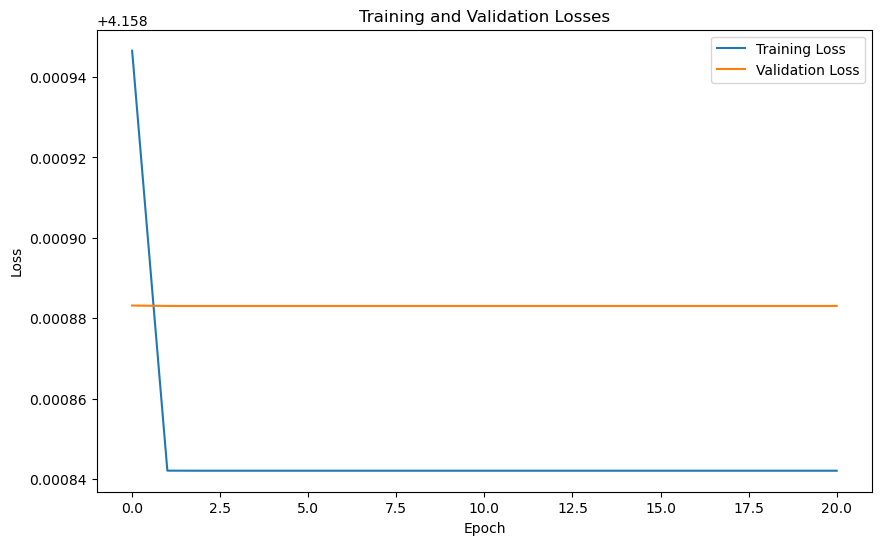

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [9]:
 # Evaluation on the test set
targets, outputs = evaluate(model, settings['DEVICE'], validation_loader)

# Compute ROC curve and ROC area
targets = np.array(targets)
outputs = np.array(outputs)

saveout = {}
saveout['fpr'], saveout['tpr'], saveout['threshold'] = roc_curve(targets, outputs)
saveout['roc_auc'] = roc_auc_score(targets, outputs)


# Plotting ROC Curve
# plt.figure()
plt.plot(saveout['fpr'], saveout['tpr'], color='darkorange', lw=2, label='Particle Net (area = %0.2f)' % saveout['roc_auc'])

/opt/conda/envs/mlllp/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1137: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


KeyError: 'roc_auc'

In [ ]:
import pickle

# Assuming the `saveout` dictionary is already populated as shown above

# Specify the filename where you want to save the dictionary
filename = 'particleNet_all_features_ROC.pkl'

# Open the file in binary write mode and save the dictionary using pickle
with open(filename, 'wb') as file:
    pickle.dump(saveout, file)